<h1><center> Homework 2: Data Preprocessing</center></h1>

## Introduction

In this assignment, we will practice using Scikit-learn for data preprocessing and regression analysis. The dataset is about fossil fuel consumption and carbon dioxide emission of cars.

## The Dataset

This is a fuel consumption dataset which contains model-specific fuel consumption ratings and estimated carbon dioxide emissions for new light-duty vehicles for retail sale in Canada. [Dataset source](http://open.canada.ca/data/en/dataset/98f1a129-f628-4ce4-b24d-6f16bf24dd64)

- **MODELYEAR** e.g. 2014
- **MAKE** e.g. Acura
- **MODEL** e.g. ILX
- **VEHICLE CLASS** e.g. SUV
- **ENGINE SIZE** e.g. 4.7
- **CYLINDERS** e.g 6
- **TRANSMISSION** e.g. A6
- **FUEL CONSUMPTION in CITY(L/100 km)** e.g. 9.9
- **FUEL CONSUMPTION in HWY (L/100 km)** e.g. 8.9
- **FUEL CONSUMPTION COMB (L/100 km)** e.g. 9.2
- **CO2 EMISSIONS (g/km)** e.g. 182   --> low --> 0

## Q1: Library and Database

#### Importing necessary packages

In [84]:
import pandas as pd
import numpy as np
import sqlalchemy as db
import matplotlib.pyplot as plt
import seaborn as sns

#### Let's first create an SQLite engine and read the 'data' Table into a variable named as 'data'. Dataset: [link](https://raw.githubusercontent.com/BlueJayADAL/DS300/master/datasets/co2.db)

In [85]:
# Need to place the sqlite database file in the same directory of the notebook
engine = db.create_engine('sqlite:///co2.db')
connection = engine.connect()
metadata = db.MetaData()
data = db.Table('data', metadata, autoload = True, autoload_with = engine)

In [86]:
data.columns.keys()

['MODELYEAR',
 'MAKE',
 'MODEL',
 'VEHICLECLASS',
 'ENGINESIZE',
 'CYLINDERS',
 'TRANSMISSION',
 'FUELTYPE',
 'FUELCONSUMPTION_CITY',
 'FUELCONSUMPTION_HWY',
 'FUELCONSUMPTION_COMB',
 'FUELCONSUMPTION_COMB_MPG',
 'CO2EMISSIONS']

#### Create a DataFrame named `df` with the given 'data' Table from the database. You need to retrieve all columns and data records from the database. 

In [87]:
# Query the table from the database
query = db.select([data])
ResultProxy = connection.execute(query)
ResultSet = ResultProxy.fetchall()


# Create a DataFrame with the table data
df = pd.DataFrame(data=ResultSet, columns=ResultSet[0].keys())



In [88]:
# take a look at the dataset
df.head()

,MODELYEAR,MAKE,MODEL,VEHICLECLASS,ENGINESIZE,CYLINDERS,TRANSMISSION,FUELTYPE,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
0,2014,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196.0
1,2014,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221.0
2,2014,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136.0
3,2014,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255.0
4,2014,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244.0


## Q2: Data Understanding

#### Check the missing data in the DataFrame and count the total occurrences for each `CYLINDERS` and `MODELYEAR` category. What do you find?

In [89]:
# Find missing data
df.isna().sum()

MODELYEAR                    0
MAKE                         0
MODEL                        0
VEHICLECLASS                 0
ENGINESIZE                   0
CYLINDERS                    0
TRANSMISSION                 0
FUELTYPE                     0
FUELCONSUMPTION_CITY         0
FUELCONSUMPTION_HWY          0
FUELCONSUMPTION_COMB        14
FUELCONSUMPTION_COMB_MPG     0
CO2EMISSIONS                 7
dtype: int64

In [90]:
# Count on 'CYLINDERS'
df['CYLINDERS'].value_counts()



4     420
6     356
8     252
12     17
10      9
5       9
3       4
Name: CYLINDERS, dtype: int64

In [91]:
# Count on 'MODELYEAR'
df['MODELYEAR'].value_counts()


2014    1067
Name: MODELYEAR, dtype: int64

## Q3: Data Cleaning

#### Delete the `MODELYEAR` column from the DataFrame since it's constant. Then delete all the data records that are missing `CO2EMISSIONS` since we can't afford to have missing labels.  Finally, impute the missing values in column `FUELCONSUMPTION_COMB` with the average of all data from that column using SimpleImputer. 

In [92]:
# Delete the 'MODELYEAR' column permanently
df.drop('MODELYEAR', axis=1, inplace=True)



In [93]:
# Delete all the data records that do not have 'CO2EMISSIONS' value.
df.dropna(subset='CO2EMISSIONS', inplace=True)



In [94]:
# Imputation on 'FUELCONSUMPTION_COMB' with average
from sklearn.impute import SimpleImputer

In [95]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
df['FUELCONSUMPTION_COMB'] = imp.fit_transform(df['FUELCONSUMPTION_COMB'].values.reshape(-1,1))

In [96]:
# Reset the index to the DataFrame as dropna() has messed it up
# Ensure not to make index as part of the columns
df.reset_index(drop=True, inplace=True)



In [97]:
## Check the missing data again to ensure the changes are made. 
df.isna().sum()



MAKE                        0
MODEL                       0
VEHICLECLASS                0
ENGINESIZE                  0
CYLINDERS                   0
TRANSMISSION                0
FUELTYPE                    0
FUELCONSUMPTION_CITY        0
FUELCONSUMPTION_HWY         0
FUELCONSUMPTION_COMB        0
FUELCONSUMPTION_COMB_MPG    0
CO2EMISSIONS                0
dtype: int64

## Q4: Data Transformation 1st Pass

#### Let's use LabelEncoder to encode the following columns:

1. Ordinal column: 'CYLINDERS'
2. Categorical columns: 'MAKE', 'MODEL'

In [98]:
from sklearn.preprocessing import LabelEncoder

In [99]:
# Encoding 'CYLINDERS', 'MAKE', 'MODEL' columns
LE = LabelEncoder()
df_le = df[['CYLINDERS', 'MAKE', 'MODEL']]
df_le = df_le.apply(LE.fit_transform)
df[['CYLINDERS', 'MAKE', 'MODEL']] = df_le

#### Display the new labels for all of these columns.

In [100]:
df['CYLINDERS'].unique()

array([1, 3, 6, 4, 5, 0, 2], dtype=int64)

In [101]:
for i in ['CYLINDERS', 'MAKE', 'MODEL']:
    print(i, df[i].unique())

CYLINDERS [1 3 6 4 5 0 2]
MAKE [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
MODEL [329 330 389 483 490 577 578 590 212 479 599 600 601  72  73  74  75  76
  77  78  79  80  81  82  83  92 441 442 443 451 452 465 466 495 496 497
 505 506 507 508 511 512 558 591 592 593 594 165 166 167 168 280 403  18
  19  20  21  22  23  24  25  26  27  28  31  32  33  34  44  45  46  47
  48  49  50  51  52  53  54  55  57  56  58  89  90  91  93  94 373 374
 375 376 613 614 615 616 617 618 619 620 621 655 656 657 237 238 239 240
 357 358 359 484 485 486 606  97  98 194 195 196 197 198 199 200 201 202
 203 247 248 559 560 643 644 645 121 122 123 124 185 190 191 192 242 243
 256 257 258 259 260 261 262 263 331 332 377 412 533 534 547 548 549 550
 555 561 562 565 566 585 586 587 588  11   7   8   9  10  12  13  14  15
  16  17 581 100 101 139 140 141 142 143 144 145 146 147 148 149 208 209
 210 211 213 214 313 352 353 354  37  38

In [102]:
# Display the new data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1060 entries, 0 to 1059
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   MAKE                      1060 non-null   int32  
 1   MODEL                     1060 non-null   int32  
 2   VEHICLECLASS              1060 non-null   object 
 3   ENGINESIZE                1060 non-null   float64
 4   CYLINDERS                 1060 non-null   int64  
 5   TRANSMISSION              1060 non-null   object 
 6   FUELTYPE                  1060 non-null   object 
 7   FUELCONSUMPTION_CITY      1060 non-null   float64
 8   FUELCONSUMPTION_HWY       1060 non-null   float64
 9   FUELCONSUMPTION_COMB      1060 non-null   float64
 10  FUELCONSUMPTION_COMB_MPG  1060 non-null   int64  
 11  CO2EMISSIONS              1060 non-null   float64
dtypes: float64(5), int32(2), int64(2), object(3)
memory usage: 91.2+ KB


## Q5: EDA 1 

#### Use visualization to find potential highly correlated columns. We want to reduce the feature dimension by removing highly correlated columns (repeated columns). Note that in each sub plot, we use `CYLINDERS` as the color hue to represent the third dimension. 

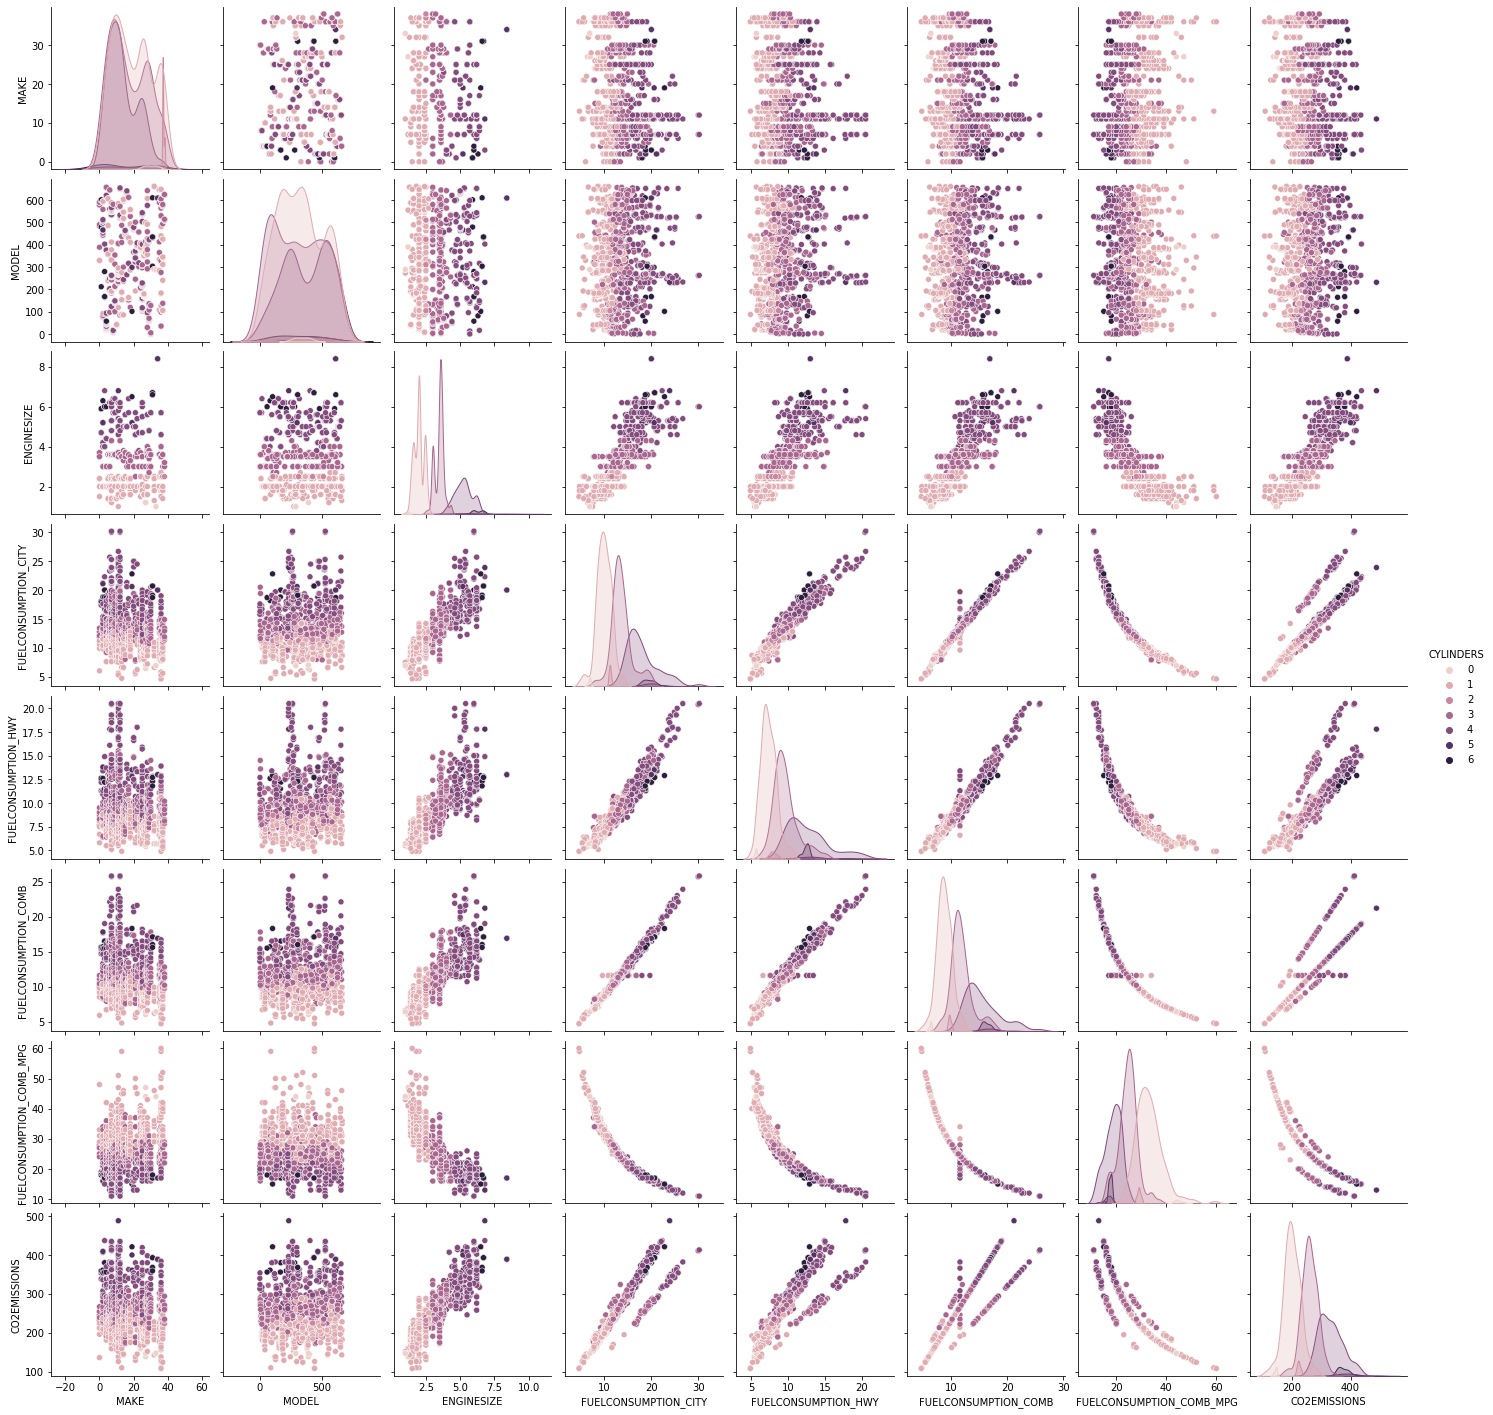

In [103]:
# Regenerate the plot below
sns.pairplot(data= df, hue='CYLINDERS')



#### Note that the columns ['FUELCONSUMPTION_CITY', 'FUELCONSUMPTION_HWY', 'FUELCONSUMPTION_COMB'] are highly correlated. We can simply keep `FUELCONSUMPTION_COMB` column and drop the other two features. 

In [104]:
df.drop(['FUELCONSUMPTION_CITY', 'FUELCONSUMPTION_HWY'], axis=1, inplace=True)


# Check the data again
df.head()

,MAKE,MODEL,VEHICLECLASS,ENGINESIZE,CYLINDERS,TRANSMISSION,FUELTYPE,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
0,0,329,COMPACT,2.0,1,AS5,Z,8.5,33,196.0
1,0,329,COMPACT,2.4,1,M6,Z,9.6,29,221.0
2,0,330,COMPACT,1.5,1,AV7,Z,5.9,48,136.0
3,0,389,SUV - SMALL,3.5,3,AS6,Z,11.1,25,255.0
4,0,483,SUV - SMALL,3.5,3,AS6,Z,10.6,27,244.0


## Q6: EDA 2

#### Validate categorical columns. 
#### Use FacetGrid to break the graph down into a number of columns with the `TRANSMISSION` feature. Show the scatter plot of `ENGINESIZE` versus `CO2EMISSIONS`.

Double click on the graph to show the details.

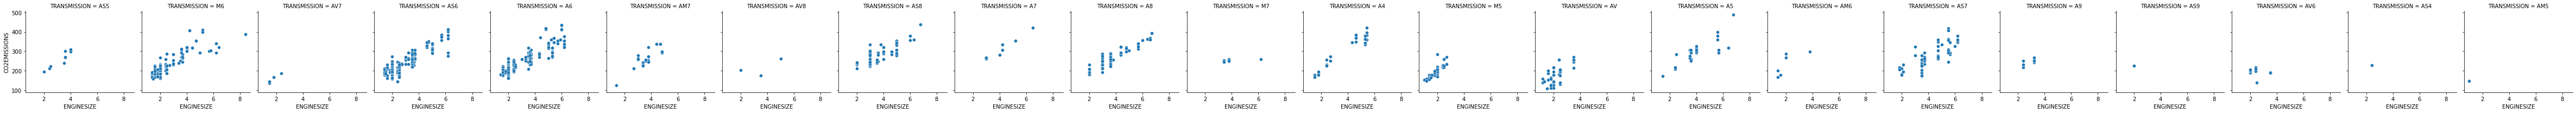

In [105]:
# Regenerate the plot below
g = sns.FacetGrid(data = df, col = 'TRANSMISSION')
g.map_dataframe(sns.scatterplot, x='ENGINESIZE', y='CO2EMISSIONS')


#### Use FacetGrid to break the graph down into a number of columns with the `FUELTYPE` feature. Show the scatter plot of `VEHICLECLASS` versus `CO2EMISSIONS`.

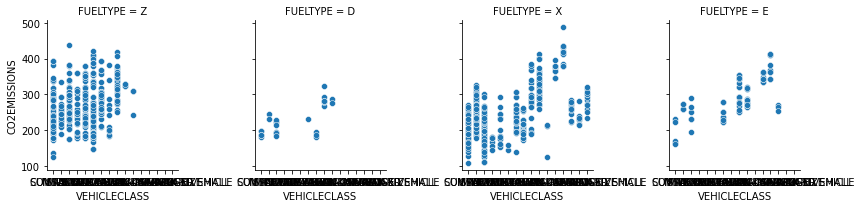

In [106]:
# Regenerate the plot below
g = sns.FacetGrid(data = df, col = 'FUELTYPE')
g.map_dataframe(sns.scatterplot, x='VEHICLECLASS', y='CO2EMISSIONS')



## Q7: Data Transformation 2nd Pass
#### We know that columns ['MAKE', 'MODEL', 'VEHICLECLASS'] may lead to biases in the model as we don't want our model to make a prediction just because it's particular car make. So let's remove these columns permanently. 

In [107]:
df.drop(['MAKE', 'MODEL', 'VEHICLECLASS'], axis=1, inplace=True)



#### From Q6 we see that `TRANSMISSION` and `FUELTYPE`  columns can make an impact to `CO2EMISSIONS`, so let's go ahead and transform these features with one-hot encoding. 

In [108]:
# Import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder


# Create OneHotEncoder Object
onehot = OneHotEncoder(drop='first')


In [109]:
# Covert the columns with OneHotEncoder object

df_onehot = df[['TRANSMISSION', 'FUELTYPE']]
df_onehot = onehot.fit_transform(df_onehot.values)


In [110]:
# Re-construct the result to a DataFrame

df_onehot = pd.DataFrame(data=df_onehot.toarray(), 
                        columns=onehot.get_feature_names_out())

In [111]:
# Update the orginal DataFrame df with the newly OneHot encoded data.

df[onehot.get_feature_names_out()] = df_onehot
df.drop(['TRANSMISSION', 'FUELTYPE'], axis=1, inplace=True)


In [112]:
# Check the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1060 entries, 0 to 1059
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ENGINESIZE                1060 non-null   float64
 1   CYLINDERS                 1060 non-null   int64  
 2   FUELCONSUMPTION_COMB      1060 non-null   float64
 3   FUELCONSUMPTION_COMB_MPG  1060 non-null   int64  
 4   CO2EMISSIONS              1060 non-null   float64
 5   x0_A5                     1060 non-null   float64
 6   x0_A6                     1060 non-null   float64
 7   x0_A7                     1060 non-null   float64
 8   x0_A8                     1060 non-null   float64
 9   x0_A9                     1060 non-null   float64
 10  x0_AM5                    1060 non-null   float64
 11  x0_AM6                    1060 non-null   float64
 12  x0_AM7                    1060 non-null   float64
 13  x0_AS4                    1060 non-null   float64
 14  x0_AS5  

## Q8: Data Splitting

#### Let's generate X, y vectors and split the X, y vectors into training and testing dataset. Use 20% as the split ratio, and use random seed as 101.

In [113]:
# Generate X, y vectors
X = df.drop('CO2EMISSIONS', axis=1)

y = df['CO2EMISSIONS']


In [114]:
from sklearn.model_selection import train_test_split

In [115]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

#### Standardize the training and testing set. 

In [116]:
from sklearn import preprocessing

In [117]:
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train, y_train)

C:\Users\augus\anaconda3\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\augus\anaconda3\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [118]:
# Checkout X_train
X_train

array([[-0.66043735, -1.10378909, -0.80475425, ..., -0.3092042 ,
         1.0142525 , -0.81810228],
       [ 1.58989264,  1.12835673,  0.21709213, ..., -0.3092042 ,
        -0.98594778,  1.22234105],
       [-0.9417286 , -1.10378909, -1.09671036, ..., -0.3092042 ,
         1.0142525 , -0.81810228],
       ...,
       [ 2.43376638,  1.12835673,  2.17319805, ..., -0.3092042 ,
        -0.98594778,  1.22234105],
       [-1.08237423, -1.10378909, -1.03831913, ..., -0.3092042 ,
         1.0142525 , -0.81810228],
       [ 0.04279077,  0.38430812, -0.25003764, ..., -0.3092042 ,
        -0.98594778,  1.22234105]])

In [119]:
# Checkout y_train
print(y_train)

320     202.0
536     283.0
403     179.0
631     361.0
1050    232.0
        ...  
575     251.0
973     297.0
75      437.0
599     184.0
863     246.0
Name: CO2EMISSIONS, Length: 848, dtype: float64


## Q9: Polynomial regression

In many cases, the trend of data is not linear but curvy. Using polynomial regression methods will make more sense. In fact, if you have learnt `polynomial series`, you know that mathematically we can represent *any* possible funciton by using a sum of polynomial terms, such as quadratic, cubic, and so on, and it can go on and on to infinite degrees.

In essence, we can call all of these, polynomial regression, where the relationship between the independent variable x and the dependent variable y is modeled as an nth degree polynomial in x. Lets say you want to have a polynomial regression (let's make 2 degree polynomial):


$y = b + \theta_1  x + \theta_2 x^2$

Now, the question is: how we can fit our data on this equation while we have only x values, such as __Engine Size__? 
Well, we can create a few additional features: 1, $x$, and $x^2$.

__PloynomialFeatures()__ function in Scikit-learn library, drives a new feature sets from the original feature set. That is, a matrix will be generated consisting of all polynomial combinations of the features with degree less than or equal to the specified degree. For example, lets say the original feature set has only one feature, _ENGINESIZE_. Now, if we select the degree of the polynomial to be 2, then it generates 3 features, degree=0, degree=1 and degree=2: 

In [120]:
# Polynomial feature generation for 'ENGINESIZE' only

from sklearn.preprocessing import PolynomialFeatures

# Column index 0 was the ENGINESIZE column before standardization
X_train_engine = X_train[0]

poly = PolynomialFeatures(degree=2)
X_train_engine_poly = poly.fit_transform(X_train_engine.reshape(-1, 1))
X_train_engine_poly

array([[ 1.00000000e+00, -6.60437355e-01,  4.36177499e-01],
       [ 1.00000000e+00, -1.10378909e+00,  1.21835035e+00],
       [ 1.00000000e+00, -8.04754249e-01,  6.47629401e-01],
       [ 1.00000000e+00,  7.52583287e-01,  5.66381604e-01],
       [ 1.00000000e+00, -1.74289044e-01,  3.03766707e-02],
       [ 1.00000000e+00, -5.02578286e-01,  2.52584934e-01],
       [ 1.00000000e+00, -1.14639323e-01,  1.31421744e-02],
       [ 1.00000000e+00, -2.90515020e-01,  8.43989770e-02],
       [ 1.00000000e+00, -9.12328038e-02,  8.32342449e-03],
       [ 1.00000000e+00, -4.86216638e-02,  2.36406619e-03],
       [ 1.00000000e+00, -7.70142721e-02,  5.93119810e-03],
       [ 1.00000000e+00, -1.74289044e-01,  3.03766707e-02],
       [ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+00, -8.44149912e-02,  7.12589074e-03],
       [ 1.00000000e+00, -4.78524302e-01,  2.28985507e-01],
       [ 1.00000000e+00, -2.73456030e-01,  7.47782003e-02],
       [ 1.00000000e+00, -2.88121586e-01

**fit_transform** takes our x values in the dataset (v1 to vn), and output a list of our data raised from power of 0 to power of 2 (since we set the degree of our polynomial to 2).

$
\begin{bmatrix}
    v_1\\
    v_2\\
    \vdots\\
    v_n
\end{bmatrix}
$
$\longrightarrow$
$
\begin{bmatrix}
    [ 1 & v_1 & v_1^2]\\
    [ 1 & v_2 & v_2^2]\\
    \vdots & \vdots & \vdots\\
    [ 1 & v_n & v_n^2]
\end{bmatrix}
$

in our example

$
\begin{bmatrix}
    2.\\
    2.4\\
    1.5\\
    \vdots
\end{bmatrix}
$
$\longrightarrow$
$
\begin{bmatrix}
    [ 1 & 2.4 & 5.67]\\
    [ 1 & 5.6 & 31.36]\\
    [ 1 & 2.0 & 4.0]\\
    \vdots & \vdots & \vdots\\
\end{bmatrix}
$

It looks like feature sets for multiple linear regression analysis, right? Yes. It does. 
Indeed, Polynomial regression is a special case of linear regression, with the main idea of how to select your features. Just consider replacing the  $x$ with $x_1$, $x_1^2$ with $x_2$, and so on. Then the degree 2 equation would be turn into:

$y = b + \theta_1  x_1 + \theta_2 x_2$

Now, we can deal with it as 'linear regression' problem. Therefore, this polynomial regression is considered to be a special case of traditional multiple linear regression. So, you can use the same mechanism as linear regression to solve such a problems. 

In sklearn, we can use __LinearRegression()__ function to solve it.

#### With the the tutorial above, now it's your turn to first generate the `Polynomial Features` on the entire `X_train` and `X_test` feature dimensions, but this time with _degree three (cubic)_. Then use _LinearRegression()_ to fit the polynomial features. 

In [121]:
# Polynomial feature generation for the entire X_train vector

from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train)

X_train_poly.shape

(848, 4495)

In [122]:
# Polynomial feature generation for the entire X_test vector
# Note: here you don't need to 'fit' as 'poly' has been fitted
# in the last cell.

X_test_poly = poly.transform(X_test)


X_test_poly.shape

C:\Users\augus\anaconda3\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name', 'str']. An error will be raised in 1.2.
  warnings.warn(


(212, 4495)

In [123]:
# Use the polynomial feature to fit a multiple linear reg model.
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [124]:
reg = LinearRegression()
reg.fit(X_train_poly, y_train)

LinearRegression()

#### Use Mean Squared Error and $R^2$ score to evaluate the performance of the trained model.

In [125]:
# Print the coefficients and intercept
pred = reg.predict(X_test_poly)
print('Mean squared error:',mean_squared_error(y_test, pred))
print('R2 score:',r2_score(y_test, pred))




Mean squared error: 1.2013277354285613e+19
R2 score: -3202896722803807.5


## Q10: Performance Evaluation and Model Tuning

#### As shown by the negative $R^2$ score above, using polynomial _degree three_ gives us an overfitted model. Let's solve this by changing the degree back to 1, and compare the $R^2$ scores.

In [126]:
poly = PolynomialFeatures(degree=1)
X_train_poly = poly.fit_transform(X_train_poly)
X_test_poly = poly.transform(X_test_poly)
reg = LinearRegression()
reg.fit(X_train_poly, y_train)
pred = reg.predict(X_test_poly)
print('Mean squared error:',mean_squared_error(y_test, pred))
print('R2 score:',r2_score(y_test, pred))

Mean squared error: 8.512531742245872e+20
R2 score: -2.2695521976171034e+17


## Bravo!! This is a very accurate and generalized model! Great job!